In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import mne

root = mne.datasets.sample.data_path() / "MEG" / "sample"
raw_file = root / "sample_audvis_filt-0-40_raw.fif"
raw = mne.io.read_raw_fif(raw_file, preload=False)

events_file = root / "sample_audvis_filt-0-40_raw-eve.fif"
events = mne.read_events(events_file)

raw.crop(tmax=90)  # in seconds (happens in-place)
# discard events >90 seconds (not strictly necessary, but avoids some warnings)
events = events[events[:, 0] <= raw.last_samp]

Opening raw data file /Users/ilyamikheev/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


In [2]:
raw.pick(["eeg", "eog"]).load_data()
raw.info

Reading 0 ... 13514  =      0.000 ...    90.001 secs...


<Info | 15 non-empty values
 bads: 1 items (EEG 053)
 ch_names: EEG 001, EEG 002, EEG 003, EEG 004, EEG 005, EEG 006, EEG 007, ...
 chs: 60 EEG, 1 EOG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 61
 projs: Average EEG reference: off
 sfreq: 150.2 Hz
>

In [3]:
channel_renaming_dict = {name: name.replace(" 0", "").lower() for name in raw.ch_names}
_ = raw.rename_channels(channel_renaming_dict)  # happens in-place

In [ ]:
raw.plot_sensors(show_names=True)
fig = raw.plot_sensors("3d")

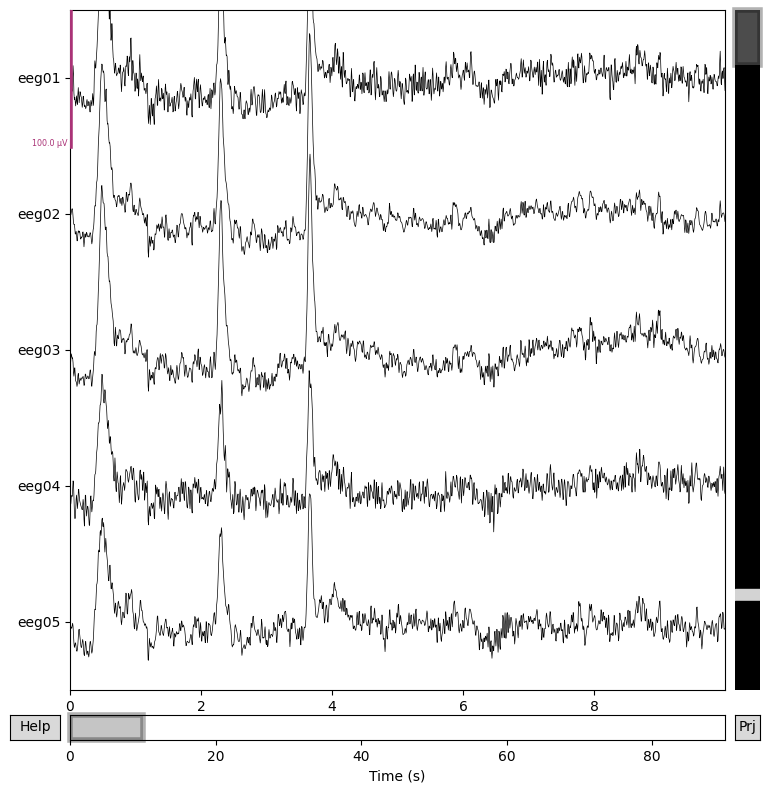

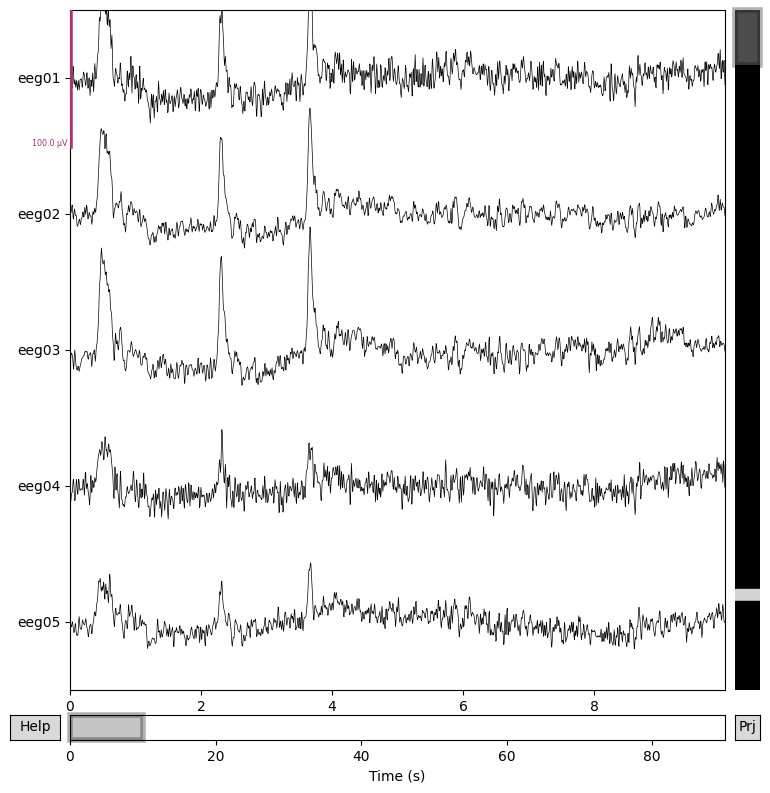

In [5]:
for proj in (False, True):
    with mne.viz.use_browser_backend("matplotlib"):
        fig = raw.plot(
            n_channels=5, proj=proj, scalings=dict(eeg=50e-6), show_scrollbars=True
        )
    fig.subplots_adjust(top=0.9)  # make room for title
    ref = "Average" if proj else "No"
    fig.suptitle(f"{ref} reference", size="xx-large", weight="bold")

In [6]:
raw.filter(l_freq=0.1, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 4957 samples (33.013 s)



<Raw | sample_audvis_filt-0-40_raw.fif, 61 x 13515 (90.0 s), ~9.2 MiB, data loaded>

In [7]:
np.unique(events[:, -1])

array([ 1,  2,  3,  4,  5, 32])

In [8]:
event_dict = {
    "auditory/left": 1,
    "auditory/right": 2,
    "visual/left": 3,
    "visual/right": 4,
    "face": 5,
    "buttonpress": 32,
}

Not setting metadata
132 matching events found
Setting baseline interval to [-0.2996928197375818, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 132 events and 151 original time points ...
1 bad epochs dropped
You seem to have overlapping epochs. Some event lines may be duplicated in the plot.


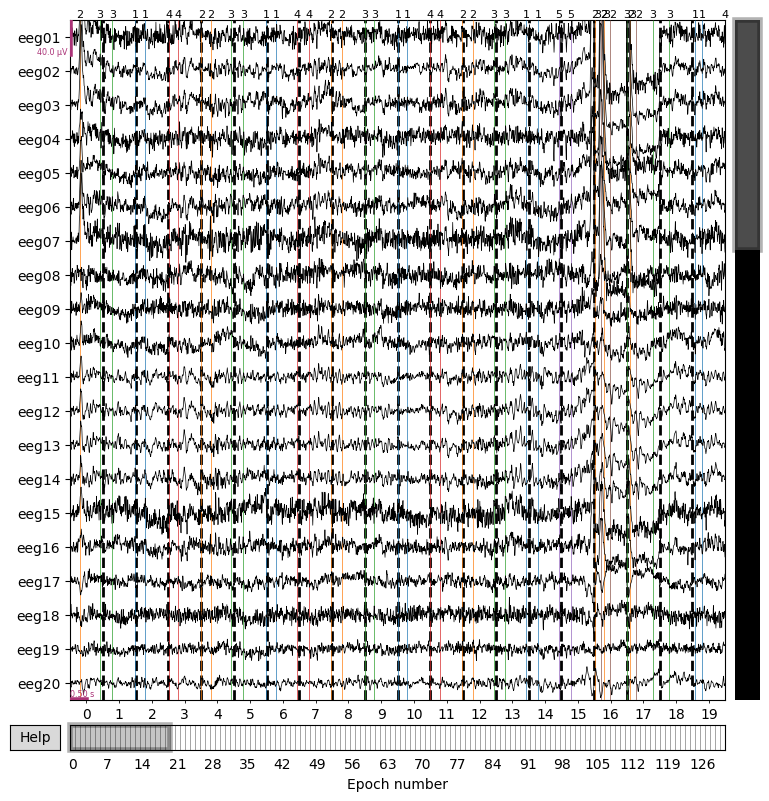

In [9]:
epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.3, tmax=0.7, preload=True)
fig = epochs.plot(events=events)

In [10]:
reject_criteria = dict(eeg=100e-6, eog=200e-6)  # 100 µV, 200 µV
epochs.drop_bad(reject=reject_criteria)

    Rejecting  epoch based on EEG : ['eeg03']
    Rejecting  epoch based on EEG : ['eeg01', 'eeg02', 'eeg03', 'eeg04', 'eeg06', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg01', 'eeg02', 'eeg03', 'eeg04', 'eeg06', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg01', 'eeg02', 'eeg03', 'eeg04', 'eeg06', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg01', 'eeg02', 'eeg03', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg01', 'eeg02', 'eeg03', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg01']
    Rejecting  epoch based on EEG : ['eeg03', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg03', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg07']
    Rejecting  epoch based on EEG : ['eeg03', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg03', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg07']
    Rejecting  epoch based on EEG : ['eeg07']
    Rejecting  epoch based on EEG : ['eeg03']
    Rejecting  epoch based on EEG : ['eeg25']
    Rejecting  epoch based on EEG : ['e

<Epochs | 114 events (all good), -0.3 – 0.699 s (baseline -0.3 – 0 s), ~10.9 MiB, data loaded,
 'auditory/left': 25
 'auditory/right': 27
 'visual/left': 28
 'visual/right': 25
 'face': 5
 'buttonpress': 4>

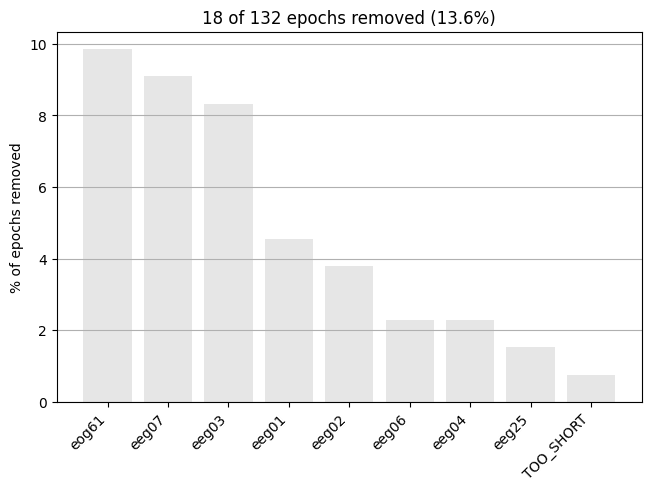

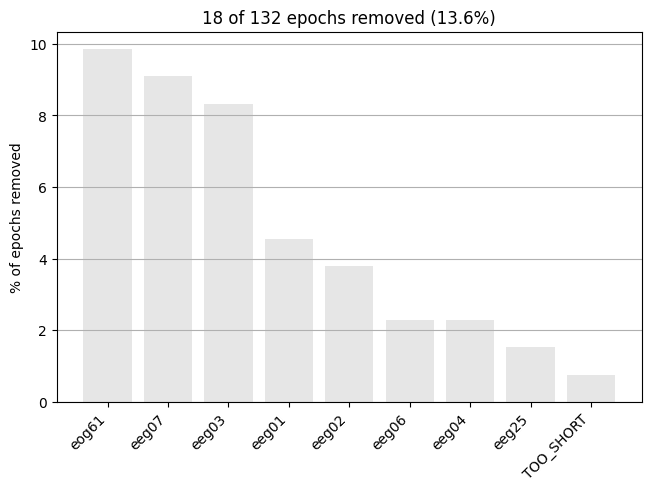

In [11]:
epochs.plot_drop_log()

In [12]:
l_aud = epochs["auditory/left"].average()
l_vis = epochs["visual/left"].average()

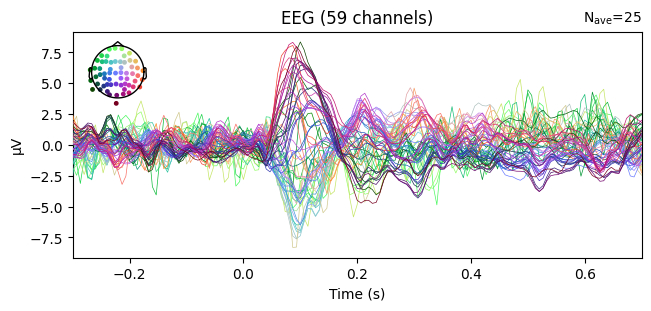

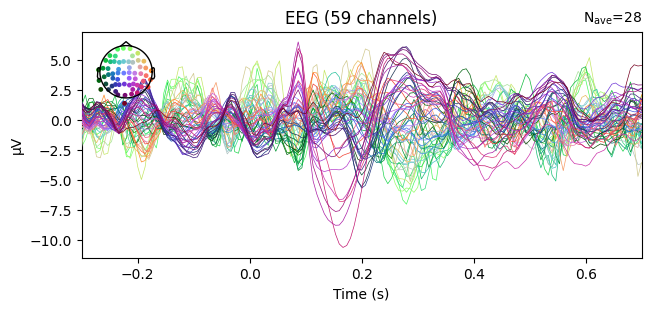

In [13]:
fig1 = l_aud.plot()
fig2 = l_vis.plot(spatial_colors=True)

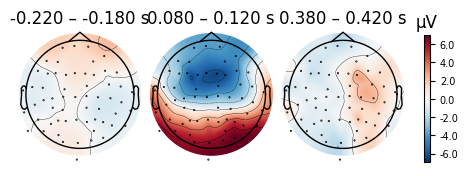

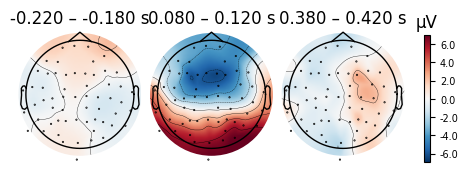

In [14]:
l_aud.plot_topomap(times=[-0.2, 0.1, 0.4], average=0.05)

Projections have already been applied. Setting proj attribute to True.


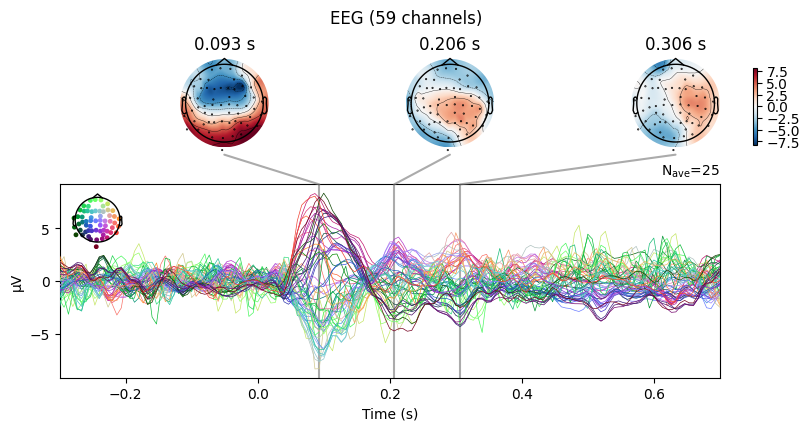

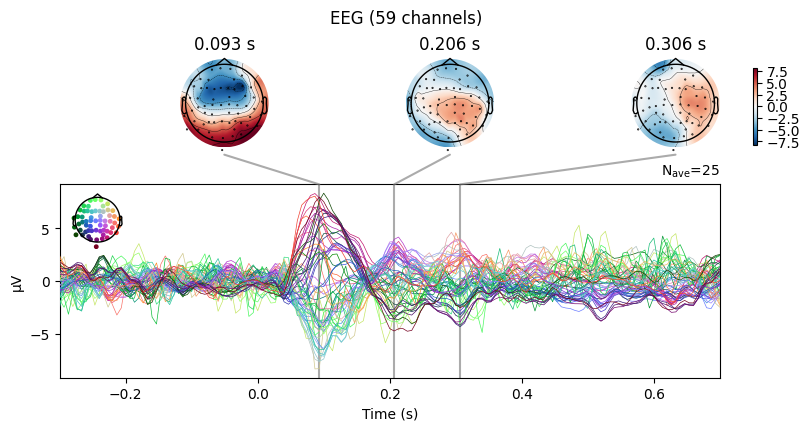

In [15]:
l_aud.plot_joint()

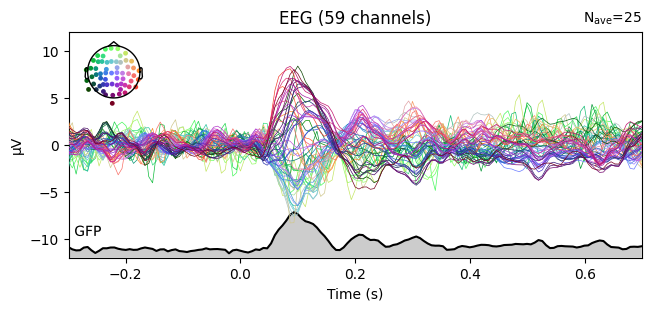

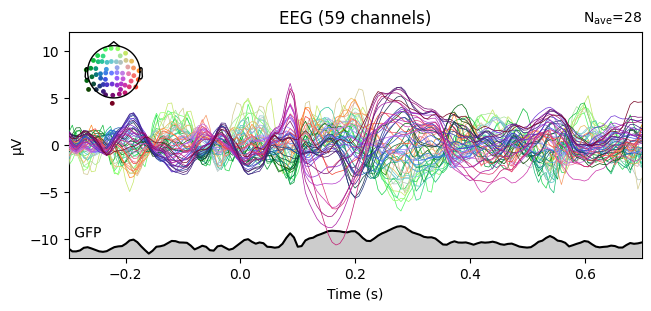

In [16]:
for evk in (l_aud, l_vis):
    evk.plot(gfp=True, spatial_colors=True, ylim=dict(eeg=[-12, 12]))

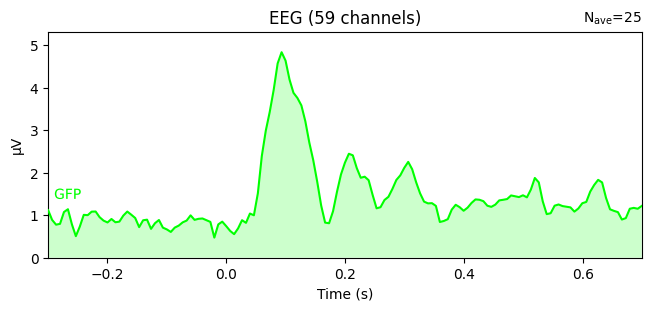

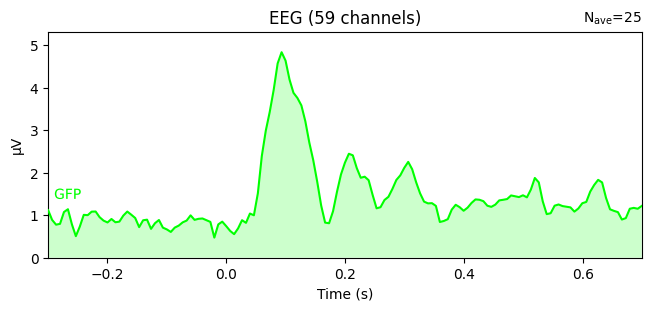

In [17]:
l_aud.plot(gfp="only")

In [18]:
gfp = l_aud.data.std(axis=0, ddof=0)

# Reproducing the MNE-Python plot style seen above
fig, ax = plt.subplots()
ax.plot(l_aud.times, gfp * 1e6, color="lime")
ax.fill_between(l_aud.times, gfp * 1e6, color="lime", alpha=0.2)
ax.set(xlabel="Time (s)", ylabel="GFP (µV)", title="EEG")

[Text(0.5, 0, 'Time (s)'), Text(0, 0.5, 'GFP (µV)'), Text(0.5, 1.0, 'EEG')]

In [22]:
l_aud.times

array([-0.29969282, -0.29303298, -0.28637314, -0.2797133 , -0.27305346,
       -0.26639362, -0.25973378, -0.25307394, -0.2464141 , -0.23975426,
       -0.23309442, -0.22643457, -0.21977473, -0.21311489, -0.20645505,
       -0.19979521, -0.19313537, -0.18647553, -0.17981569, -0.17315585,
       -0.16649601, -0.15983617, -0.15317633, -0.14651649, -0.13985665,
       -0.13319681, -0.12653697, -0.11987713, -0.11321729, -0.10655745,
       -0.09989761, -0.09323777, -0.08657793, -0.07991809, -0.07325824,
       -0.0665984 , -0.05993856, -0.05327872, -0.04661888, -0.03995904,
       -0.0332992 , -0.02663936, -0.01997952, -0.01331968, -0.00665984,
        0.        ,  0.00665984,  0.01331968,  0.01997952,  0.02663936,
        0.0332992 ,  0.03995904,  0.04661888,  0.05327872,  0.05993856,
        0.0665984 ,  0.07325824,  0.07991809,  0.08657793,  0.09323777,
        0.09989761,  0.10655745,  0.11321729,  0.11987713,  0.12653697,
        0.13319681,  0.13985665,  0.14651649,  0.15317633,  0.15

In [21]:
gfp

array([1.10852706e-06, 8.82053311e-07, 7.70304801e-07, 7.89728129e-07,
       1.06541413e-06, 1.12995942e-06, 7.79219732e-07, 5.02524891e-07,
       7.26107720e-07, 9.99180194e-07, 9.92243504e-07, 1.07393003e-06,
       1.07705109e-06, 9.45352194e-07, 8.64891449e-07, 8.21826530e-07,
       9.02795686e-07, 8.26353480e-07, 8.41510388e-07, 9.82101022e-07,
       1.07590313e-06, 1.00317453e-06, 9.25979495e-07, 7.13145995e-07,
       8.73052439e-07, 8.86664698e-07, 6.72819614e-07, 8.04578101e-07,
       8.79529576e-07, 7.01175366e-07, 6.59587966e-07, 6.01212979e-07,
       7.02151948e-07, 7.48624211e-07, 8.24360144e-07, 8.66077156e-07,
       9.87545107e-07, 8.82691199e-07, 9.06578431e-07, 9.14676000e-07,
       8.75478467e-07, 8.34915690e-07, 4.68687334e-07, 7.77044036e-07,
       8.40953525e-07, 7.36477901e-07, 6.24756485e-07, 5.49527946e-07,
       6.83162417e-07, 8.75089826e-07, 8.13154192e-07, 1.03026008e-06,
       9.88970849e-07, 1.50203792e-06, 2.37140729e-06, 2.95976238e-06,
      

In [19]:
left = ["eeg17", "eeg18", "eeg25", "eeg26"]
right = ["eeg23", "eeg24", "eeg34", "eeg35"]

left_ix = mne.pick_channels(l_aud.info["ch_names"], include=left)
right_ix = mne.pick_channels(l_aud.info["ch_names"], include=right)

In [23]:
left_ix

array([16, 17, 24, 25])

Applying baseline correction (mode: mean)
['left_ROI', 'right_ROI']


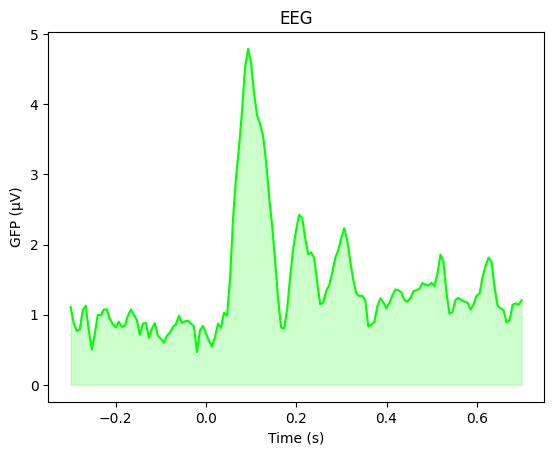

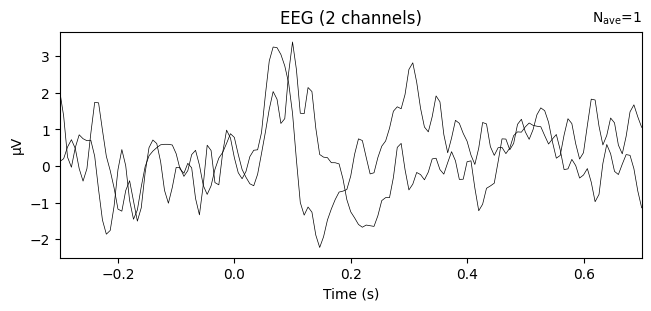

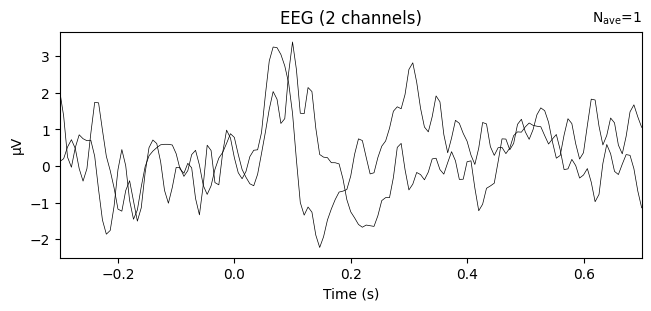

In [20]:
roi_dict = dict(left_ROI=left_ix, right_ROI=right_ix)
roi_evoked = mne.channels.combine_channels(l_aud, roi_dict, method="mean")
print(roi_evoked.info["ch_names"])
roi_evoked.plot()

combining channels using "mean"
combining channels using "mean"


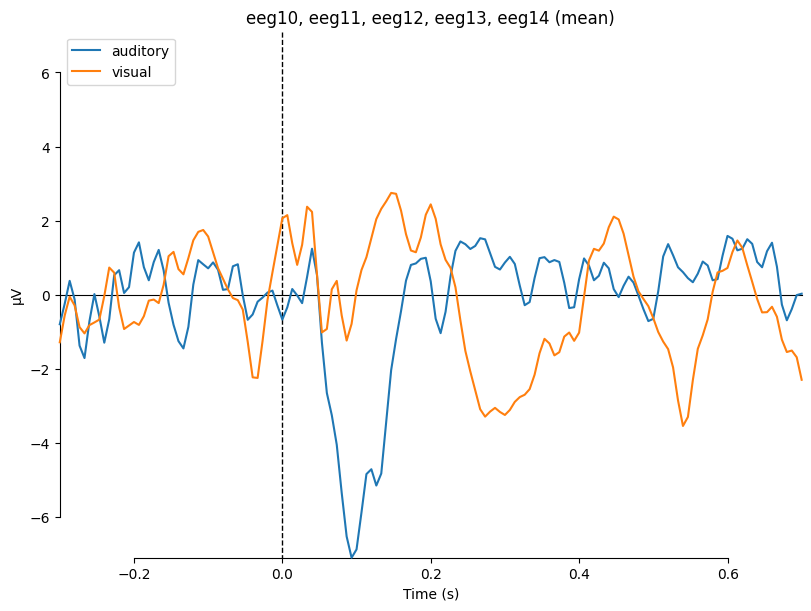

[<Figure size 800x600 with 1 Axes>]

In [24]:
evokeds = dict(auditory=l_aud, visual=l_vis)
picks = [f"eeg{n}" for n in range(10, 15)]
mne.viz.plot_compare_evokeds(evokeds, picks=picks, combine="mean")

combining channels using "mean"
combining channels using "mean"


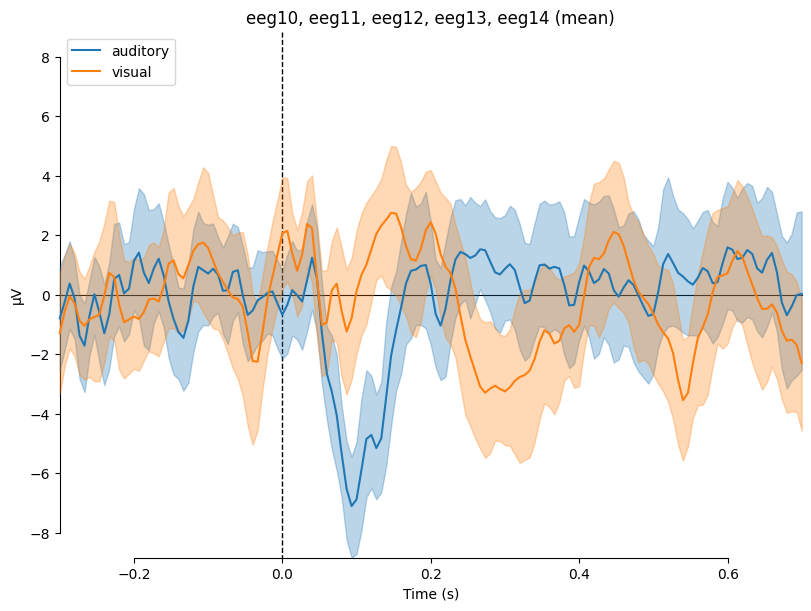

[<Figure size 800x600 with 1 Axes>]

In [25]:
evokeds = dict(
    auditory=list(epochs["auditory/left"].iter_evoked()),
    visual=list(epochs["visual/left"].iter_evoked()),
)
mne.viz.plot_compare_evokeds(evokeds, combine="mean", picks=picks)

Projections have already been applied. Setting proj attribute to True.


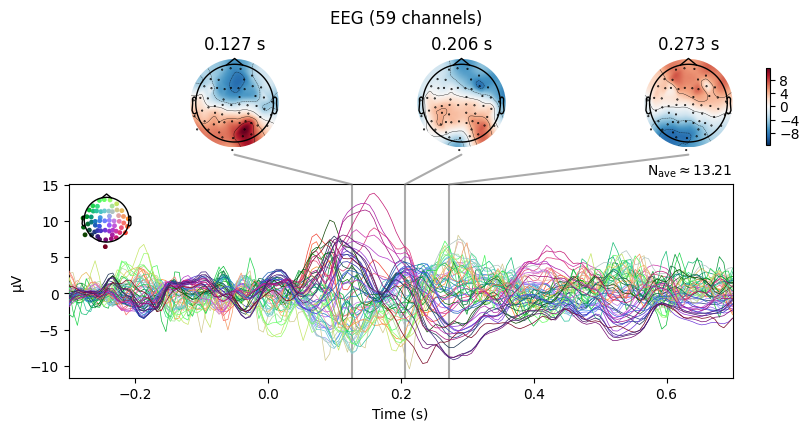

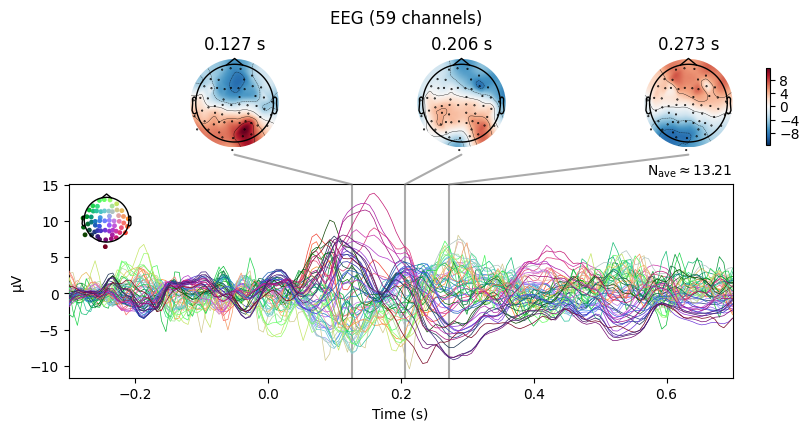

In [26]:
aud_minus_vis = mne.combine_evoked([l_aud, l_vis], weights=[1, -1])
aud_minus_vis.plot_joint()

In [27]:
grand_average = mne.grand_average([l_aud, l_vis])
print(grand_average)

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.2 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 1 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.2 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 1 sensors
Identifying common channels ...
<Evoked | 'Grand average (n = 2)' (average, N=2), -0.29969 – 0.69928 s, baseline -0.299693 – 0 s, 60 ch, ~3.0 MiB>


In [28]:
list(event_dict)

['auditory/left',
 'auditory/right',
 'visual/left',
 'visual/right',
 'face',
 'buttonpress']

In [29]:
epochs["auditory"].average()

<Evoked | '0.48 × auditory/left + 0.52 × auditory/right' (average, N=52), -0.29969 – 0.69928 s, baseline -0.299693 – 0 s, 60 ch, ~3.0 MiB>

In [32]:
def print_peak_measures(ch, tmin, tmax, lat, amp):
    print(f"Channel: {ch}")
    print(f"Time Window: {tmin * 1e3:.3f} - {tmax * 1e3:.3f} ms")
    print(f"Peak Latency: {lat * 1e3:.3f} ms")
    print(f"Peak Amplitude: {amp * 1e6:.3f} µV")


# Get peak amplitude and latency from a good time window that contains the peak
good_tmin, good_tmax = 0.08, 0.12
ch, lat, amp = l_vis.get_peak(
    ch_type="eeg", tmin=good_tmin, tmax=good_tmax, mode="pos", return_amplitude=True
)

# Print output from the good time window that contains the peak
print("** PEAK MEASURES FROM A GOOD TIME WINDOW **")
print_peak_measures(ch, good_tmin, good_tmax, lat, amp)

** PEAK MEASURES FROM A GOOD TIME WINDOW **
Channel: eeg55
Time Window: 80.000 - 120.000 ms
Peak Latency: 86.578 ms
Peak Amplitude: 6.508 µV


In [33]:
# Fist, return a copy of l_vis to select the channel from
l_vis_roi = l_vis.copy().pick("eeg59")

# Get the peak and latency measure from the selected channel
ch_roi, lat_roi, amp_roi = l_vis_roi.get_peak(
    tmin=good_tmin, tmax=good_tmax, mode="pos", return_amplitude=True
)

# Print output
print("** PEAK MEASURES FOR ONE CHANNEL FROM A GOOD TIME WINDOW **")
print_peak_measures(ch_roi, good_tmin, good_tmax, lat_roi, amp_roi)

** PEAK MEASURES FOR ONE CHANNEL FROM A GOOD TIME WINDOW **
Channel: eeg59
Time Window: 80.000 - 120.000 ms
Peak Latency: 86.578 ms
Peak Amplitude: 5.713 µV


In [34]:
# Get BAD peak measures
bad_tmin, bad_tmax = 0.095, 0.135
ch_roi, bad_lat_roi, bad_amp_roi = l_vis_roi.get_peak(
    mode="pos", tmin=bad_tmin, tmax=bad_tmax, return_amplitude=True
)

# Print output
print("** PEAK MEASURES FOR ONE CHANNEL FROM A BAD TIME WINDOW **")
print_peak_measures(ch_roi, bad_tmin, bad_tmax, bad_lat_roi, bad_amp_roi)

** PEAK MEASURES FOR ONE CHANNEL FROM A BAD TIME WINDOW **
Channel: eeg59
Time Window: 95.000 - 135.000 ms
Peak Latency: 99.898 ms
Peak Amplitude: 1.487 µV


In [35]:
fig, axs = plt.subplots(nrows=2, ncols=1, layout="tight")
words = (("Bad", "missing"), ("Good", "finding"))
times = (np.array([bad_tmin, bad_tmax]), np.array([good_tmin, good_tmax]))
colors = ("C1", "C0")

for ix, ax in enumerate(axs):
    title = "{} time window {} peak".format(*words[ix])
    l_vis_roi.plot(axes=ax, time_unit="ms", show=False, titles=title)
    ax.plot(lat_roi * 1e3, amp_roi * 1e6, marker="*", color="C6")
    ax.axvspan(*(times[ix] * 1e3), facecolor=colors[ix], alpha=0.3)
    ax.set_xlim(-50, 150)  # Show zoomed in around peak

Need more than one channel to make topography for eeg. Disabling interactivity.
Need more than one channel to make topography for eeg. Disabling interactivity.


In [36]:
# Select all of the channels and crop to the time window
channels = ["eeg54", "eeg57", "eeg55", "eeg59"]
hemisphere = ["left", "left", "right", "right"]
l_vis_mean_roi = l_vis.copy().pick(channels).crop(tmin=good_tmin, tmax=good_tmax)

# Extract mean amplitude in µV over time
mean_amp_roi = l_vis_mean_roi.data.mean(axis=1) * 1e6

# Store the data in a data frame
mean_amp_roi_df = pd.DataFrame(
    {
        "ch_name": l_vis_mean_roi.ch_names,
        "hemisphere": ["left", "left", "right", "right"],
        "mean_amp": mean_amp_roi,
    }
)

# Print the data frame
print(mean_amp_roi_df.groupby("hemisphere").mean(numeric_only=True))

            mean_amp
hemisphere          
left       -0.279764
right       0.685840


In [37]:
# Extract mean amplitude for all channels in l_vis (including `eog`)
l_vis_cropped = l_vis.copy().crop(tmin=good_tmin, tmax=good_tmax)
mean_amp_all = l_vis_cropped.data.mean(axis=1) * 1e6
mean_amp_all_df = pd.DataFrame(
    {"ch_name": l_vis_cropped.info["ch_names"], "mean_amp": mean_amp_all}
)
mean_amp_all_df["tmin"] = good_tmin
mean_amp_all_df["tmax"] = good_tmax
mean_amp_all_df["condition"] = "Left/Visual"
with pd.option_context("display.max_columns", None):
    print(mean_amp_all_df.head())
    print(mean_amp_all_df.tail())

  ch_name  mean_amp  tmin  tmax    condition
0   eeg01 -1.689513  0.08  0.12  Left/Visual
1   eeg02 -0.078492  0.08  0.12  Left/Visual
2   eeg03 -0.381191  0.08  0.12  Left/Visual
3   eeg04 -1.609264  0.08  0.12  Left/Visual
4   eeg05 -1.113717  0.08  0.12  Left/Visual
   ch_name  mean_amp  tmin  tmax    condition
55   eeg56  2.064174  0.08  0.12  Left/Visual
56   eeg57 -0.259681  0.08  0.12  Left/Visual
57   eeg58  0.156472  0.08  0.12  Left/Visual
58   eeg59  0.802306  0.08  0.12  Left/Visual
59   eeg60  0.878811  0.08  0.12  Left/Visual
